# Lab Assignment - 5
## CS22B1096 Pratyek Thumula 
### Autoencoders

### Q1 - MNIST dataset compression and reconstruction using PCA and AutoEncoder

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [71]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

train_images, _ = next(iter(train_loader))
test_images, _ = next(iter(test_loader))

train_images = train_images.view(-1, 784).numpy()
test_images = test_images.view(-1, 784).numpy()

print("Train data shape:", train_images.shape)  
print("Test data shape:", test_images.shape) 

Train data shape: (60000, 784)
Test data shape: (10000, 784)


### Training a PCA model 

In [72]:
pca = PCA(n_components=4)
train_pca = pca.fit_transform(train_images)
test_pca = pca.transform(test_images)

train_pca_recon = pca.inverse_transform(train_pca)
test_pca_recon = pca.inverse_transform(test_pca)

print("PCA Compressed Shape:", train_pca.shape) 
print("PCA Reconstructed Shape:", train_pca_recon.shape)  

PCA Compressed Shape: (60000, 4)
PCA Reconstructed Shape: (60000, 784)


In [73]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4),  # Bottleneck layer
            nn.ReLU()
        )

        self.decoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()  # Output pixels in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = AutoEncoder()

criterion = nn.MSELoss() 
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

### Training an AutoEncoder

In [74]:
train_tensor = torch.tensor(train_images, dtype=torch.float32)
test_tensor = torch.tensor(test_images, dtype=torch.float32)

num_epochs = 10
batch_size = 256

for epoch in range(num_epochs):
    for i in range(0, len(train_tensor), batch_size):
        batch = train_tensor[i:i+batch_size]

        # Forward pass
        outputs = autoencoder(batch)
        loss = criterion(outputs, batch)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

with torch.no_grad():
    train_ae = autoencoder.encoder(train_tensor).numpy()
    test_ae = autoencoder.encoder(test_tensor).numpy()

    train_ae_recon = autoencoder(train_tensor).numpy()
    test_ae_recon = autoencoder(test_tensor).numpy()

Epoch [1/20], Loss: 0.0580
Epoch [2/20], Loss: 0.0497
Epoch [3/20], Loss: 0.0469
Epoch [4/20], Loss: 0.0451
Epoch [5/20], Loss: 0.0437
Epoch [6/20], Loss: 0.0428
Epoch [7/20], Loss: 0.0420
Epoch [8/20], Loss: 0.0412
Epoch [9/20], Loss: 0.0405
Epoch [10/20], Loss: 0.0397
Epoch [11/20], Loss: 0.0394
Epoch [12/20], Loss: 0.0389
Epoch [13/20], Loss: 0.0383
Epoch [14/20], Loss: 0.0380
Epoch [15/20], Loss: 0.0377
Epoch [16/20], Loss: 0.0373
Epoch [17/20], Loss: 0.0370
Epoch [18/20], Loss: 0.0367
Epoch [19/20], Loss: 0.0365
Epoch [20/20], Loss: 0.0363


### Visualization of the latent vectors using TSNE

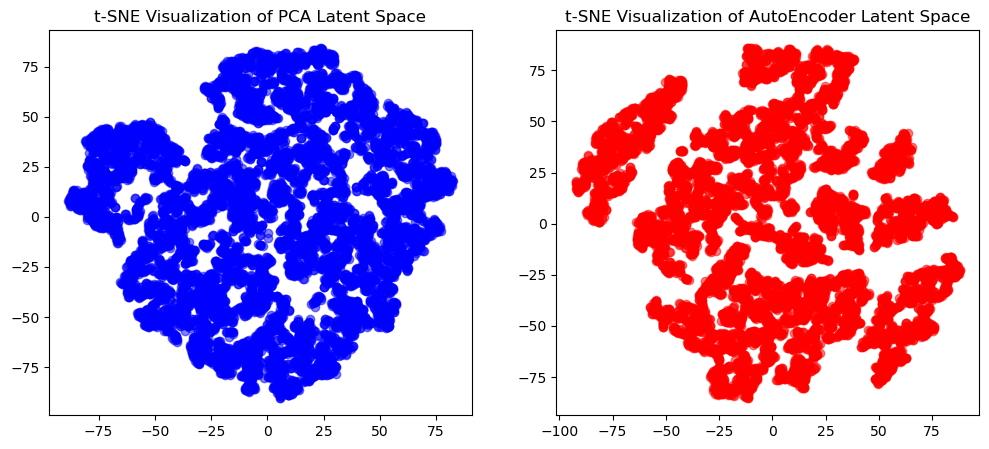

In [75]:
tsne_pca = TSNE(n_components=2, random_state=42).fit_transform(test_pca)
tsne_ae = TSNE(n_components=2, random_state=42).fit_transform(test_ae)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(tsne_pca[:, 0], tsne_pca[:, 1], c='blue', alpha=0.5)
plt.title("t-SNE Visualization of PCA Latent Space")

plt.subplot(1, 2, 2)
plt.scatter(tsne_ae[:, 0], tsne_ae[:, 1], c='red', alpha=0.5)
plt.title("t-SNE Visualization of AutoEncoder Latent Space")

plt.show()

### Reconstruction 

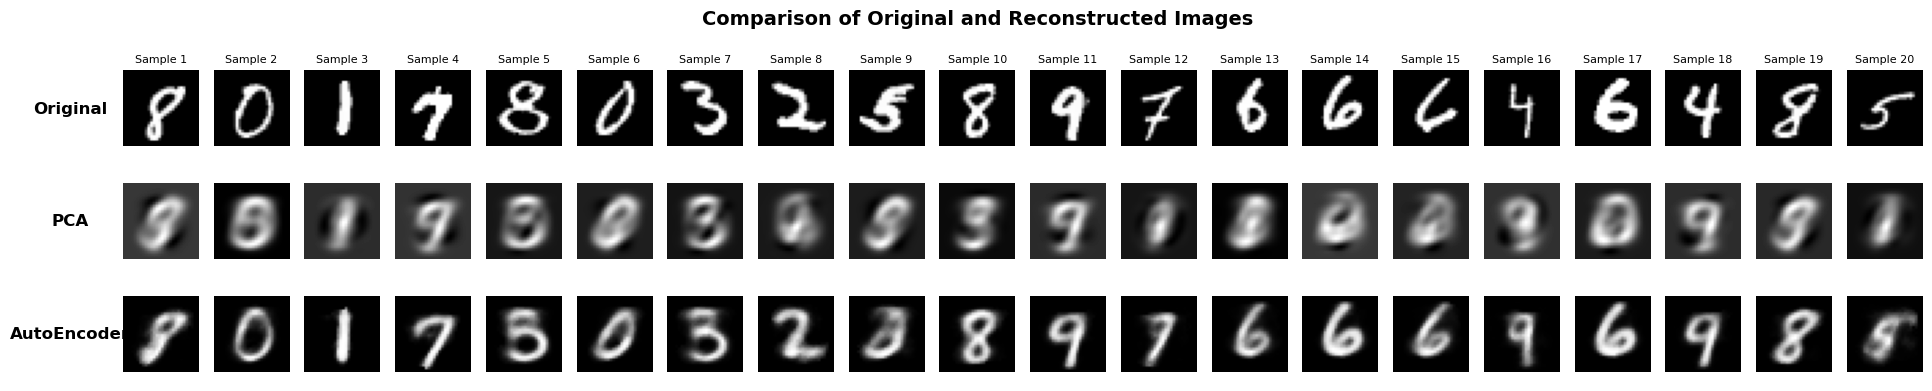

In [76]:
num_samples = 20
random_samples = np.random.randint(0, test_images.shape[0], num_samples)

original_images = test_images[random_samples].reshape(-1, 28, 28)
pca_recon_images = test_pca_recon[random_samples].reshape(-1, 28, 28)
ae_recon_images = test_ae_recon[random_samples].reshape(-1, 28, 28)

def plot_images(original, pca, autoencoder, num_samples=10):
    fig, axes = plt.subplots(3, num_samples+1, figsize=(num_samples+1, 4))
    
    row_titles = ["Original", "PCA", "AutoEncoder"]
    
    for row in range(3):
        axes[row, 0].axis('off')
        axes[row, 0].text(0.5, 0.5, row_titles[row], ha='center', va='center',
                          fontsize=12, fontweight='bold')
    
    for i in range(num_samples):
        axes[0, i+1].imshow(original[i], cmap='gray')
        axes[0, i+1].axis('off')
        axes[1, i+1].imshow(pca[i], cmap='gray')
        axes[1, i+1].axis('off')
        axes[2, i+1].imshow(autoencoder[i], cmap='gray')
        axes[2, i+1].axis('off')
        
        axes[0, i+1].set_title(f"Sample {i+1}", fontsize=8)
    
    fig.suptitle("Comparison of Original and Reconstructed Images", fontsize=14, fontweight='bold')
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.85, bottom=0.05)
    plt.show()

plot_images(original_images, pca_recon_images, ae_recon_images, num_samples=20)

In [3]:
original_size = 784 
compressed_size = 4
compression_ratio = original_size / compressed_size

print(f"Compression Ratio: {compression_ratio:.4f}")


Compression Ratio: 196.0000


### Q2 - Train an autoencoder model for anomaly classification

In [2]:
import os
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from PIL import Image

In [79]:
dataset_path = "/kaggle/input/lab_5/isic2020"
train_csv_path = os.path.join(dataset_path, "train.csv")

train_df = pd.read_csv(train_csv_path)

non_melanoma_df = train_df[train_df['target'] == 0]

train_image_paths = [os.path.join(dataset_path, "train", img + ".jpg") for img in non_melanoma_df['image_name']]

print(f"Total Non-Melanoma Images: {len(train_image_paths)}")


Total Non-Melanoma Images: 29978


In [80]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
])

class ISICDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Load image
        if self.transform:
            img = self.transform(img)
        return img  # Return only image as Tensor


In [81]:
train_dataset = ISICDataset(train_image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Total Training Batches: {len(train_loader)}")


Total Training Batches: 937


In [82]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # 64x64x16
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 32x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 16x16x64
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16*16*64, 4),  # 4D latent space
        )

        self.decoder = nn.Sequential(
            nn.Linear(4, 16*16*64),
            nn.ReLU(),
            nn.Unflatten(1, (64, 16, 16)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64x16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128x3
            nn.Tanh()  # Output in [-1,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = AutoEncoder().cuda()

criterion = nn.MSELoss()  # Minimize reconstruction error
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)


### latent dimension is 4

### Training

In [83]:
num_epochs = 20

for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_loader:
        images = batch.cuda()
        optimizer.zero_grad()

        # Forward pass
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.0346
Epoch [2/20], Loss: 0.0208
Epoch [3/20], Loss: 0.0201
Epoch [4/20], Loss: 0.0195
Epoch [5/20], Loss: 0.0190
Epoch [6/20], Loss: 0.0188
Epoch [7/20], Loss: 0.0185
Epoch [8/20], Loss: 0.0184
Epoch [9/20], Loss: 0.0182
Epoch [10/20], Loss: 0.0181
Epoch [11/20], Loss: 0.0180
Epoch [12/20], Loss: 0.0179
Epoch [13/20], Loss: 0.0178
Epoch [14/20], Loss: 0.0177
Epoch [15/20], Loss: 0.0176
Epoch [16/20], Loss: 0.0176
Epoch [17/20], Loss: 0.0175
Epoch [18/20], Loss: 0.0175
Epoch [19/20], Loss: 0.0174
Epoch [20/20], Loss: 0.0174


### Reconstruction Error

In [84]:
test_csv_path = os.path.join(dataset_path, "test.csv")
test_df = pd.read_csv(test_csv_path)

test_image_paths = [os.path.join(dataset_path, "test", img + ".jpg") for img in test_df['image_name']]

test_dataset = ISICDataset(test_image_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

reconstruction_errors = []
autoencoder.eval()

with torch.no_grad():
    for img in test_loader:
        img = img.cuda()
        reconstructed_img = autoencoder(img)
        loss = criterion(reconstructed_img, img)  # MSE Loss
        reconstruction_errors.append(loss.item())

reconstruction_errors = np.array(reconstruction_errors)


### Threshold Value of Reconstruction error

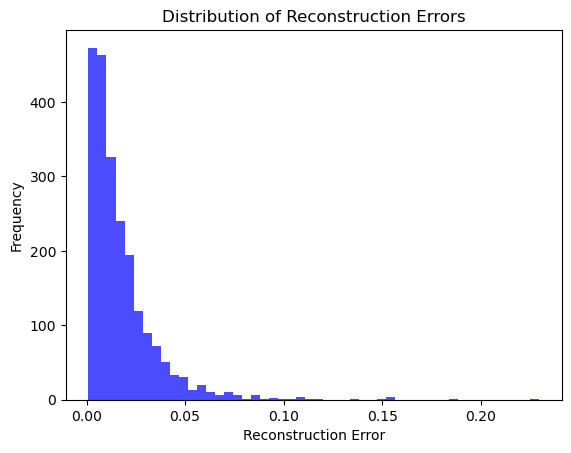

Threshold for anomaly detection: 0.0482


In [85]:
plt.hist(reconstruction_errors, bins=50, color='blue', alpha=0.7)
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Reconstruction Errors")
plt.show()

threshold = np.percentile(reconstruction_errors, 95)
print(f"Threshold for anomaly detection: {threshold:.4f}")


### tSNE Plot

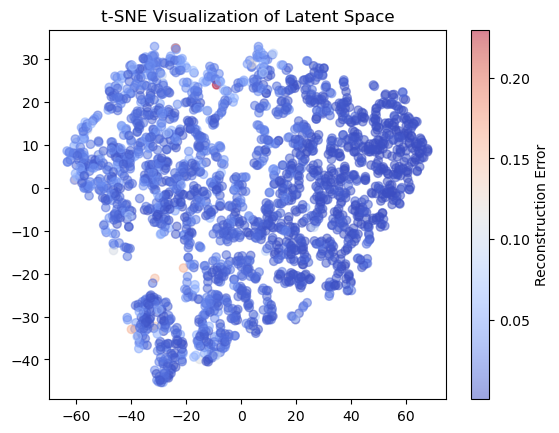

In [86]:
latent_vectors = []

with torch.no_grad():
    for img in test_loader:
        img = img.cuda()
        latent_vector = autoencoder.encoder(img).cpu().numpy()
        latent_vectors.append(latent_vector)

latent_vectors = np.array(latent_vectors).squeeze()

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(latent_vectors)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=reconstruction_errors, cmap='coolwarm', alpha=0.5)
plt.colorbar(label="Reconstruction Error")
plt.title("t-SNE Visualization of Latent Space")
plt.show()


## Q3 - Training a VAE model for generating new data similar to training set.

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
])

# Load dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

print("FashionMNIST dataset loaded successfully!")

FashionMNIST dataset loaded successfully!


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=10):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        
        # Latent space
        self.mu_layer = nn.Linear(256, latent_dim)  
        self.log_var_layer = nn.Linear(256, latent_dim)  
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Tanh()  # Output in [-1,1]
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std) 
        return mu + eps * std

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu = self.mu_layer(x)
        log_var = self.log_var_layer(x)
        
        # Reparameterization
        z = self.reparameterize(mu, log_var)
        
        # Decode
        out = self.decoder(z)
        return out, mu, log_var

def vae_loss(reconstructed_x, x, mu, log_var):
    reconstruction_loss = nn.functional.mse_loss(reconstructed_x, x, reduction="sum")
    
    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return reconstruction_loss + kl_divergence


### Training 

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=10).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0
    for batch, _ in train_loader:
        batch = batch.view(-1, 28 * 28).to(device)  # Flatten images

        optimizer.zero_grad()
        
        # Forward pass
        reconstructed_batch, mu, log_var = vae(batch)
        
        # Compute loss
        loss = vae_loss(reconstructed_batch, batch, mu, log_var)
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch [1/50], Loss: 107.0744
Epoch [2/50], Loss: 73.7965
Epoch [3/50], Loss: 69.0089
Epoch [4/50], Loss: 66.3849
Epoch [5/50], Loss: 64.7719
Epoch [6/50], Loss: 63.6786
Epoch [7/50], Loss: 62.9058
Epoch [8/50], Loss: 62.2237
Epoch [9/50], Loss: 61.7606
Epoch [10/50], Loss: 61.2676
Epoch [11/50], Loss: 60.8295
Epoch [12/50], Loss: 60.6014
Epoch [13/50], Loss: 60.2281
Epoch [14/50], Loss: 59.9595
Epoch [15/50], Loss: 59.7392
Epoch [16/50], Loss: 59.5357
Epoch [17/50], Loss: 59.3170
Epoch [18/50], Loss: 59.1249
Epoch [19/50], Loss: 58.9872
Epoch [20/50], Loss: 58.7930
Epoch [21/50], Loss: 58.6223
Epoch [22/50], Loss: 58.5526
Epoch [23/50], Loss: 58.3677
Epoch [24/50], Loss: 58.2525
Epoch [25/50], Loss: 58.1731
Epoch [26/50], Loss: 58.1185
Epoch [27/50], Loss: 57.9471
Epoch [28/50], Loss: 57.8676
Epoch [29/50], Loss: 57.7841
Epoch [30/50], Loss: 57.6450
Epoch [31/50], Loss: 57.6242
Epoch [32/50], Loss: 57.4949
Epoch [33/50], Loss: 57.4457
Epoch [34/50], Loss: 57.4151
Epoch [35/50], Loss: 5

### Generating 30 new samples using the learned model and ploting them

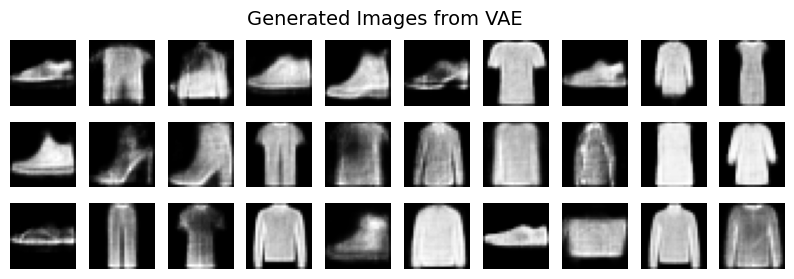

In [30]:
vae.eval()

z_samples = torch.randn(30, 10).to(device)

with torch.no_grad():
    generated_images = vae.decoder(z_samples).cpu().numpy()

generated_images = generated_images.reshape(-1, 28, 28)
fig, axes = plt.subplots(3, 10, figsize=(10, 3))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i], cmap="gray")
    ax.axis("off")

plt.suptitle("Generated Images from VAE", fontsize=14)
plt.show()
